In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import pandas as pd
from tqdm import tqdm
import os
import os
from sklearn.metrics import confusion_matrix

In [2]:
def find_best_percent(result, granularity_all=1000):
    """
    find threshold
    :param result: sorted result
    :param granularity_all: granularity_all
    """
    max_percent = 0
    best_n = 1
    print("threshold tuning start:")
    for n in tqdm(range(1, 100)):
        head_n = n / granularity_all
        data_length = max(round(len(result) * head_n), 1)
        count_dist = count_entries(result.loc[:data_length - 1], 'label')
        try:
            percent = count_dist['1'] / (count_dist['0'] + count_dist['1'])
        except KeyError:
            print("can't find n%,take 1%")
            percent = 0.01
        if percent > max_percent:
            max_percent = percent
            best_n = n
    print("top %d / %s is the highest, %s" % (granularity_all, best_n, max_percent))
    return best_n, max_percent, granularity_all

def count_entries(df, col_name):
    """
    count
    """
    count_dist = {'0': 0, '1': 0}
    col = df[col_name]
    for entry in col:
        if str(int(entry)) in count_dist.keys():
            count_dist[str(int(entry))] = count_dist[str(int(entry))] + 1
        else:
            count_dist[str(int(entry))] = 1
    return count_dist

def find_best_result(threshold_n, result, dataframe_std):
    """
    find_best_result
    :param threshold_n: threshold
    :param result: sorted result
    :param dataframe_std: label
    """
    best_result, best_h, best_re, best_fa, best_f1, best_precision = None, 0, 0, 0, 0, 0
    best_auroc = 0
    for h in tqdm(range(50, 1000, 50)):
        train_result = charge_to_car(threshold_n, result, head_n=h)
        f1, recall, false_rate, precision, accuracy, auroc = evaluation(dataframe_std, train_result)
        if auroc >= best_auroc:
            best_f1 = f1
            best_h = h
            best_re = recall
            best_fa = false_rate
            best_result = train_result
            best_auroc = auroc
    return best_result, best_h, best_re, best_fa, best_f1, best_auroc

def charge_to_car(threshold_n, rec_result, head_n=92):
    """
    mapping from charge to car
    :param threshold_n: threshold
    :param rec_result: sorted result
    :param head_n: top %n
    :param gran: granularity
    """
    gran = 1000
    result = []
    for grp in rec_result.groupby('car'):
        temp = grp[1].values[:, -1].astype(float)
        idx = max(round(head_n / gran * len(temp)), 1)
        error = np.mean(temp[:idx])
        result.append([grp[0], int(error > threshold_n), error, threshold_n])
    return pd.DataFrame(result, columns=['car', 'predict', 'error', 'threshold_n'])

def evaluation(dataframe_std, dataframe):
    """
    calculated statistics
    :param dataframe_std:
    :param dataframe:
    :return:
    """

    # calculate auroc
#     print(dataframe) # error car
    _label = []
    for each_car in dataframe['car']:
        if int(each_car) in ind_car_num_list:
            _label.append(0)
        if int(each_car) in ood_car_num_list:
            _label.append(1)

    fpr, tpr, thresholds = metrics.roc_curve(_label, list(dataframe['error']), pos_label=1)
    auroc = auc(fpr, tpr)


    data = pd.merge(dataframe_std, dataframe, on='car')
    cm = confusion_matrix(data['label'].astype(int), data['predict'].astype(int))
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0
    false_rate = fp / (tn + fp) if tn + fp != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if tp + tn + fp + fn != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0
    return f1, recall, false_rate, precision, accuracy, auroc

# You should change the following path.

In [5]:
test_res_csv_fold0 = pd.read_csv('../DyAD/dyad_vae_save/2022-09-08-10-56-31_fold0/result/test_segment_scores.csv')
test_res_csv_fold1 = pd.read_csv('../DyAD/dyad_vae_save/2022-02-23-22-43-46_fold1/result/test_segment_scores.csv')
test_res_csv_fold2 = pd.read_csv('../DyAD/dyad_vae_save/2022-02-23-22-43-51_fold2/result/test_segment_scores.csv')
test_res_csv_fold3 = pd.read_csv('../DyAD/dyad_vae_save/2022-02-23-22-41-48_fold3/result/test_segment_scores.csv')
test_res_csv_fold4 = pd.read_csv('../DyAD/dyad_vae_save/2022-02-23-22-43-48_fold4/result/test_segment_scores.csv')
train_res_csv_fold0 = pd.read_csv('../DyAD/dyad_vae_save/2022-09-08-10-56-31_fold0/result/train_segment_scores.csv')
train_res_csv_fold1 = pd.read_csv('../DyAD/dyad_vae_save/2022-02-23-22-43-46_fold1/result/train_segment_scores.csv')
train_res_csv_fold2 = pd.read_csv('../DyAD/dyad_vae_save/2022-02-23-22-43-51_fold2/result/train_segment_scores.csv')
train_res_csv_fold3 = pd.read_csv('../DyAD/dyad_vae_save/2022-02-23-22-41-48_fold3/result/train_segment_scores.csv')
train_res_csv_fold4 = pd.read_csv('../DyAD/dyad_vae_save/2022-02-23-22-43-48_fold4/result/train_segment_scores.csv')

In [6]:
# replace the following two car number lists
ind_ood_car_dict = np.load('../five_fold_utils/ind_odd_dict1.npz.npy', allow_pickle=True).item()
ind_car_num_list = ind_ood_car_dict['ind_sorted']
ood_car_num_list = ind_ood_car_dict['ood_sorted'] 
all_car_num_list = set(ind_car_num_list + ood_car_num_list)
print(len(ind_car_num_list))
print(len(ood_car_num_list))

168
30


len(test_car_list) 57
test_car_list {129, 3, 136, 138, 21, 150, 152, 153, 157, 158, 31, 34, 163, 36, 45, 173, 47, 174, 177, 50, 51, 49, 181, 54, 183, 182, 57, 186, 185, 184, 61, 190, 191, 66, 195, 194, 196, 68, 197, 72, 78, 79, 87, 92, 94, 95, 98, 99, 102, 103, 105, 107, 108, 114, 115, 119, 125}


 25%|██▌       | 25/99 [00:00<00:00, 238.67it/s]

threshold tuning start:


  5%|▌         | 1/19 [00:00<00:02,  8.34it/s]

top 1000 / 4 is the highest, 0.0573025856044724
threshold_n 0.07084409147500992
start tuning, flag is rec_error


100%|██████████| 19/19 [00:02<00:00,  7.65it/s]


dataframe_std is  348 &&   dataframe is  141
best 1000 / 950:
re: 0.0
fa: 0.007407407407407408
F1: 0
len(_score) 57
AUC 0.8737373737373738

len(test_car_list) 58
test_car_list {2, 131, 130, 6, 7, 8, 136, 10, 140, 13, 142, 15, 141, 146, 18, 148, 21, 22, 23, 24, 150, 29, 160, 166, 41, 169, 171, 46, 175, 48, 174, 182, 183, 56, 185, 184, 187, 62, 191, 64, 192, 194, 196, 68, 198, 197, 75, 78, 86, 91, 93, 98, 101, 107, 108, 110, 116, 119}


NameError: name 'train_res_csv_fold1' is not defined

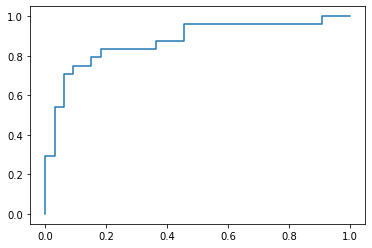

In [7]:
AUC_fivefold_list = []

for i in range(5):
    
    fold_num = i
    test_car_list = ind_car_num_list[int(fold_num * len(ind_car_num_list) / 5):int((fold_num + 1) * len(ind_car_num_list) / 5)] + ood_car_num_list[:int(fold_num * len(ood_car_num_list) / 5)] + ood_car_num_list[int((fold_num + 1) * len(ood_car_num_list) / 5):]
    test_car_list = set(test_car_list)
    train_car_list = all_car_num_list - test_car_list
    print('len(test_car_list)', len(test_car_list))
    print('test_car_list', test_car_list)
    
    train_res_csv = pd.DataFrame()
    test_res_csv = pd.DataFrame()
    for each_car in train_car_list:
        train_res_csv = pd.concat([train_res_csv, eval('train_res_csv_fold%d' % i)[eval('train_res_csv_fold%d' % i)['car']==each_car]], axis=0,ignore_index=True)
        train_res_csv = pd.concat([train_res_csv, eval('test_res_csv_fold%d' % i)[eval('test_res_csv_fold%d' % i)['car']==each_car]], axis=0,ignore_index=True)
    for each_car in test_car_list:
        test_res_csv = pd.concat([test_res_csv, eval('train_res_csv_fold%d' % i)[eval('train_res_csv_fold%d' % i)['car']==each_car]], axis=0,ignore_index=True)
        test_res_csv = pd.concat([test_res_csv, eval('test_res_csv_fold%d' % i)[eval('test_res_csv_fold%d' % i)['car']==each_car]], axis=0,ignore_index=True)
    
    
    train_res_csv = np.array(train_res_csv)[:, 1:]
    test_res_csv = np.array(test_res_csv)[:, 1:]
    train_res_csv = np.vstack((train_res_csv[:,1], train_res_csv[:,0], train_res_csv[:,2])).T
    test_res_csv = np.vstack((test_res_csv[:,1], test_res_csv[:,0], test_res_csv[:,2])).T
    
#     print(train_res_csv[5:,])
#     print(test_res_csv[5:,])
#     assert 1==0
    
    rec_sorted_index = np.argsort(-train_res_csv[:, 2].astype(float))
    res = [train_res_csv[i][[1, 0, 2]] for i in rec_sorted_index]
    result = pd.DataFrame(res, columns=['car', 'label', 'rec_error'])
    result['car'] = result['car'].astype("int").astype("str")
    
    best_n, max_percent, granularity = find_best_percent(result, granularity_all=1000)
    head_n = best_n / granularity
    data_length = round(len(result) * head_n)
    threshold_n = result['rec_error'].values[data_length - 1].astype(float)
    
    print("threshold_n", threshold_n)
    print("start tuning, flag is", 'rec_error')
    # dtype = object
    dataframe_std1 = pd.read_csv(os.path.join('../data/battery_brand1/label', "train_label.csv"), dtype=object)
    dataframe_std2 = pd.read_csv(os.path.join('../data/battery_brand1/label', "test_label.csv"), dtype=object)
    dataframe_std3 = pd.read_csv(os.path.join('../data/battery_brand2/label', "train_label.csv"), dtype=object)
    dataframe_std4 = pd.read_csv(os.path.join('../data/battery_brand2/label', "test_label.csv"), dtype=object)
    dataframe_std5 = pd.read_csv(os.path.join('../data/battery_brand4/label', "all_label.csv"), dtype=object)
    dataframe_std = pd.concat([dataframe_std1, dataframe_std2, dataframe_std3, dataframe_std4, dataframe_std5], axis=0,ignore_index=True)
    assert max(dataframe_std['car'].astype("int"))>300
    assert 201 in dataframe_std['car'].astype("int")
    best_result, best_h, best_re, best_fa, best_f1, best_auroc = find_best_result(threshold_n, result, dataframe_std)
    # best_result.to_csv(os.path.join(self.args.result_path, "train_res.csv")),
    if dataframe_std.shape[0] == best_result.shape[0]:
        pass
    else:
        print('dataframe_std is ', dataframe_std.shape[0], '&&   dataframe is ', best_result.shape[0])
    print("best 1000 / %d:" % best_h)
    print("re:", best_re)
    print("fa:", best_fa)
    print("F1:", best_f1)
    
    rec_sorted_index = np.argsort(-test_res_csv[:, 2].astype(float))
    res = [test_res_csv[i][[1, 0, 2]] for i in rec_sorted_index]
    result = pd.DataFrame(res, columns=['car', 'label', 'rec_error'])
    result['car'] = result['car'].astype("int").astype("str")
    # result.to_csv(os.path.join(self.args.result_path, "test_segment_scores.csv"))
    test_result = charge_to_car(threshold_n, result, head_n=best_h)
    
    _score = list(test_result['error'])
    _label = []
    for each_car in test_result['car']:
        if int(each_car) in ind_car_num_list:
            _label.append(0)
        if int(each_car) in ood_car_num_list:
            _label.append(1)
    
    print('len(_score)', len(_score))
    fpr, tpr, thresholds = metrics.roc_curve(_label, _score, pos_label=1)
    plt.plot(fpr, tpr)
#     plt.show()
    AUC = auc(fpr, tpr)
    print('AUC', AUC)
    
    os.makedirs('../DyAD/auc', exist_ok=True)
    np.save('../DyAD/auc/robust_all_score_fold%d' % fold_num, _score)
    np.save('../DyAD/auc/robust_labels_fold%d' % fold_num, _label)
    
    AUC_fivefold_list.append(AUC)
    print()

print('AUC mean ', np.mean(AUC_fivefold_list))


In [13]:
plt.show()